# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
!pip install mplcyberpunk
import mplcyberpunk

plt.style.use("cyberpunk")

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
# Виведемо перші 5 рядків для перевірки
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

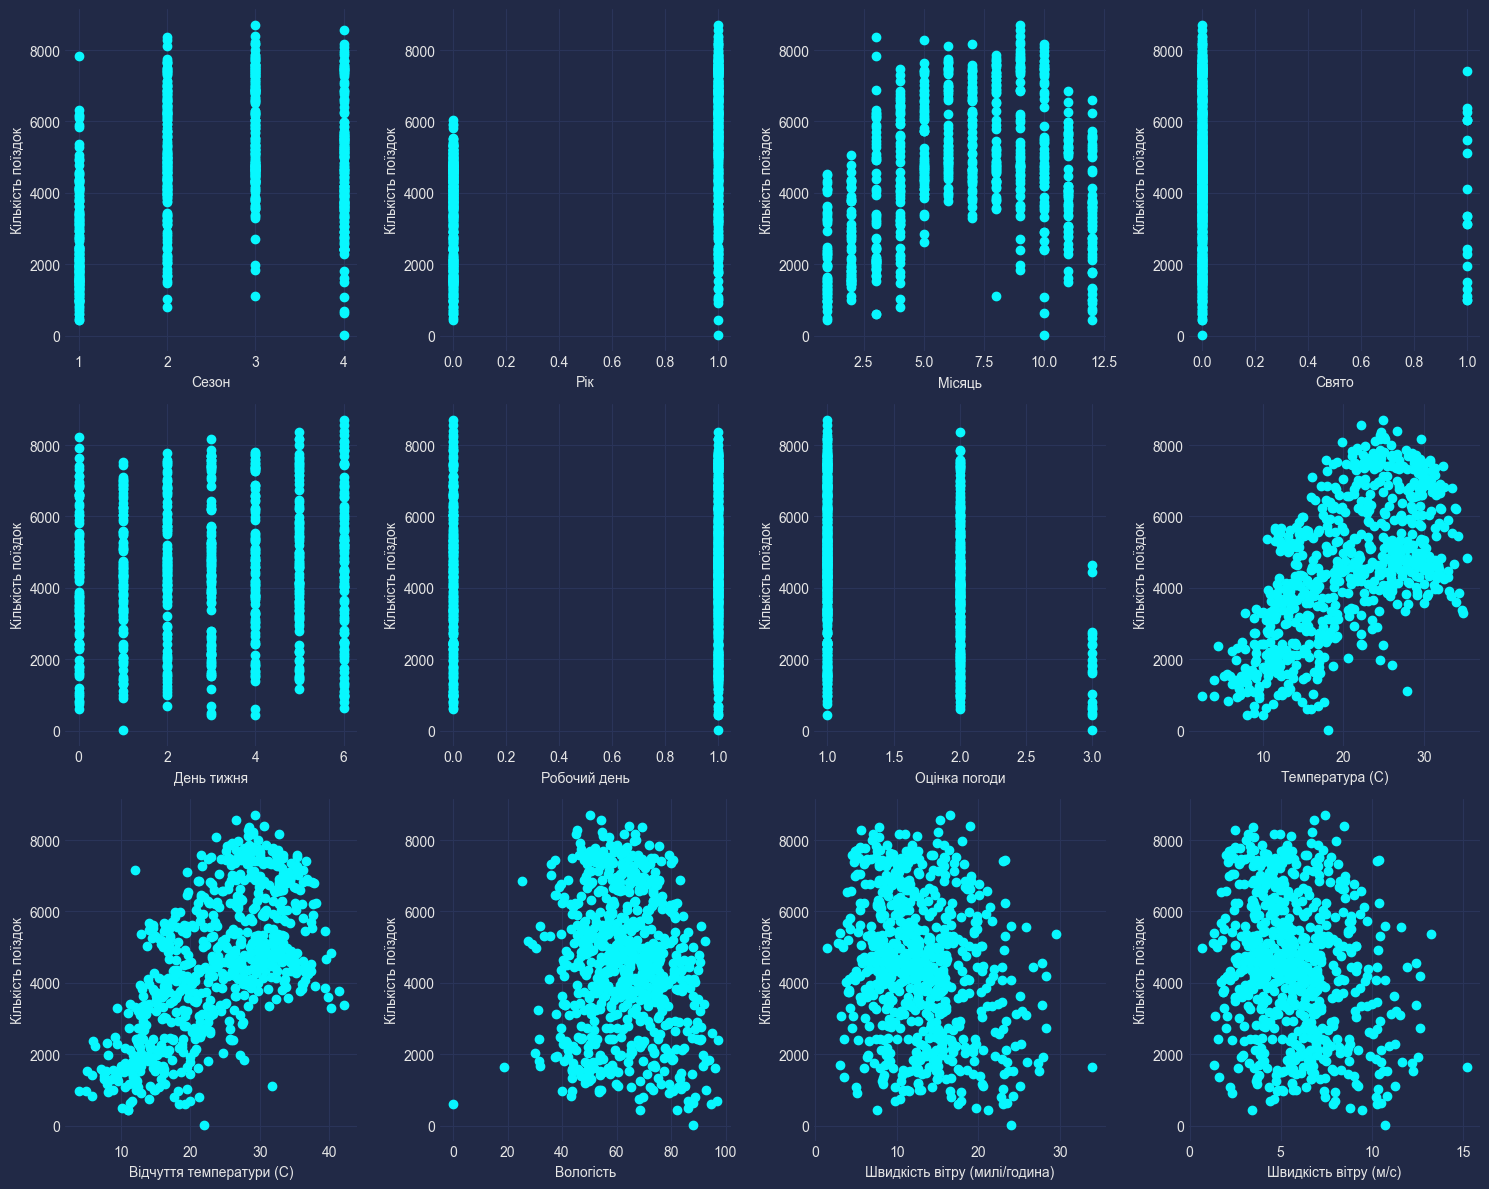

In [3]:
# Побудуємо графіки залежності атрибутів від кількості поїздок
plt.figure(figsize=(15, 12))

# Графік 1: Залежність від сезону
plt.subplot(3, 4, 1)
plt.scatter(df['season'], df['cnt'])
plt.xlabel('Сезон')
plt.ylabel('Кількість поїздок')

# Графік 2: Залежність від року
plt.subplot(3, 4, 2)
plt.scatter(df['yr'], df['cnt'])
plt.xlabel('Рік')
plt.ylabel('Кількість поїздок')

# Графік 3: Залежність від місяця
plt.subplot(3, 4, 3)
plt.scatter(df['mnth'], df['cnt'])
plt.xlabel('Місяць')
plt.ylabel('Кількість поїздок')

# Графік 4: Залежність від свята
plt.subplot(3, 4, 4)
plt.scatter(df['holiday'], df['cnt'])
plt.xlabel('Свято')
plt.ylabel('Кількість поїздок')

# Графік 5: Залежність від дня тижня
plt.subplot(3, 4, 5)
plt.scatter(df['weekday'], df['cnt'])
plt.xlabel('День тижня')
plt.ylabel('Кількість поїздок')

# Графік 6: Залежність від робочого дня
plt.subplot(3, 4, 6)
plt.scatter(df['workingday'], df['cnt'])
plt.xlabel('Робочий день')
plt.ylabel('Кількість поїздок')

# Графік 7: Залежність від погоди
plt.subplot(3, 4, 7)
plt.scatter(df['weathersit'], df['cnt'])
plt.xlabel('Оцінка погоди')
plt.ylabel('Кількість поїздок')

# Графік 8: Залежність від температури
plt.subplot(3, 4, 8)
plt.scatter(df['temp'], df['cnt'])
plt.xlabel('Температура (C)')
plt.ylabel('Кількість поїздок')

# Графік 9: Залежність від температури за відчуттями
plt.subplot(3, 4, 9)
plt.scatter(df['atemp'], df['cnt'])
plt.xlabel('Відчуття температури (C)')
plt.ylabel('Кількість поїздок')

# Графік 10: Залежність від вологості
plt.subplot(3, 4, 10)
plt.scatter(df['hum'], df['cnt'])
plt.xlabel('Вологість')
plt.ylabel('Кількість поїздок')

# Графік 11: Залежність від швидкості вітру (милі на годину)
plt.subplot(3, 4, 11)
plt.scatter(df['windspeed(mph)'], df['cnt'])
plt.xlabel('Швидкість вітру (милі/година)')
plt.ylabel('Кількість поїздок')

# Графік 12: Залежність від швидкості вітру (метри за секунду)
plt.subplot(3, 4, 12)
plt.scatter(df['windspeed(ms)'], df['cnt'])
plt.xlabel('Швидкість вітру (м/с)')
plt.ylabel('Кількість поїздок')

plt.tight_layout()
plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

Щодо характеру залежності кількості прокатів від місяця:

1. Залежність від місяця має сезонний характер. Кількість прокатів зазвичай збільшується влітку і зменшується взимку.
2. Щодо однієї чи двох ознак, від яких кількість прокатів швидше за все залежить лінійно, можна вважати, що "температура" (temp) та "температура по відчуттях" (atemp) є кандидатами на такі ознаки, оскільки зазвичай
більше людей орендує велосипеди в теплу погоду, і ця залежність може бути приблизно лінійною.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

Для розрахунку кореляції між ознаками і цільовою змінною можна використовувати метод corrwith для об'єкта DataFrame. Давайте порахуємо кореляції між всіма ознаками (крім останньої, тобто "cnt") та "cnt":

In [4]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


Цей код розрахує кореляцію між кожною ознакою (крім "cnt") та "cnt". Результат буде представлений у вигляді серії кореляцій для кожної ознаки.

Щодо оцінки кореляцій між речовими ознаками, ви можете використовувати функцію corr для підрахунку кореляційної матриці між всіма речовими ознаками:

In [5]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])  # Відберемо речові ознаки
correlation_matrix = numeric_features.corr()
print(correlation_matrix)

                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

Цей код розрахує кореляційну матрицю між всіма речовими ознаками в вашому наборі даних.

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

Для обчислення попарних кореляцій між ознаками 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)' та 'cnt', і виведення середніх значень признаків, такий код:

In [6]:
# Обчислення кореляцій
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
print("Матриця кореляцій:")
print(correlation_matrix)

# Виведення середніх значень признаків
mean_features = df.mean()
print("\nСередні значення признаків:")
print(mean_features)

Матриця кореляцій:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  

Середні значення признаків:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349

Цей код обчислює кореляції між вказаними ознаками і виводить матрицю кореляцій. Помітно, що 'temp' і 'atemp' мають високу кореляцію, і 'windspeed(mph)' та 'windspeed(ms)' також корелюють (це очевидно, бо одне є іншим в інших одиницях). Середні значення признаків виводяться також для оцінки масштабу ознак і долі одиниць у бінарних ознаках.

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

Для виведення середніх значень ознак і подальших дій, таких як стандартизація та навчання лінійної регресії, такий код:

In [7]:
# Виведення середніх значень признаків
mean_features = df.mean()
print(mean_features)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
# Використання змішування для перемішування даних
from sklearn.utils import shuffle
df_shuffled = shuffle(df, random_state=42)

# Стандартизація признаків
from sklearn.preprocessing import scale
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
# Навчання лінійної регресії
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

# Виведення ваг признаків (коефіцієнтів)
coefficients = model.coef_
print(coefficients)

[ 5.70863642e+02  1.02196042e+03 -1.41300633e+02 -8.67576047e+01
  1.37227258e+02  5.63898036e+01 -3.30227183e+02  3.67479903e+02
  5.85552180e+02 -1.45615523e+02  1.24543563e+13 -1.24543563e+13]


Цей код виводить середні значення признаків, змішує дані для крос-валідації, стандартизує признаки, навчає модель лінійної регресії та виводить ваги (коефіцієнти) признаків після навчання моделі.

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [10]:
from sklearn.linear_model import LinearRegression

# Створення об'єкта лінійного регресора
model = LinearRegression()

# Навчання моделі на всіх даних
model.fit(X, y)

# Отримання ваг моделі
weights = list(zip(df.columns[:-1], model.coef_))

# Виведення пар (назва ознаки, вага)
for feature, weight in weights:
    print(f"{feature}: {weight}")
# Put your code here

season: 570.863641661725
yr: 1021.9604245185086
mnth: -141.3006331900142
holiday: -86.75760471139698
weekday: 137.2272583151452
workingday: 56.38980357474366
weathersit: -330.2271825899341
temp: 367.4799030832653
atemp: 585.5521797658965
hum: -145.6155228231448
windspeed(mph): 12454356291009.727
windspeed(ms): -12454356291208.188


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

Для навчання лінійних моделей з L1 і L2-регуляризацією (Lasso і Ridge) та виведення їх ваг можна використовувати наступний код:

In [11]:
from sklearn.linear_model import Lasso, Ridge

# Навчання моделі Lasso (L1-регуляризація)
lasso_model = Lasso()
lasso_model.fit(X, y)

# Отримання ваг моделі Lasso
lasso_weights = list(zip(df.columns[:-1], lasso_model.coef_))

# Виведення пар (назва ознаки, вага) для Lasso
print("Ваги для моделі Lasso:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")


Ваги для моделі Lasso:
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [12]:
# Навчання моделі Ridge (L2-регуляризація)
ridge_model = Ridge()
ridge_model.fit(X, y)

# Отримання ваг моделі Ridge
ridge_weights = list(zip(df.columns[:-1], ridge_model.coef_))

# Виведення пар (назва ознаки, вага) для Ridge
print("\nВаги для моделі Ridge:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")


Ваги для моделі Ridge:
season: 563.0645722520164
yr: 1018.9483787875275
mnth: -131.87332028247582
holiday: -86.74609799709243
weekday: 138.00511117871926
workingday: 55.90311037506429
weathersit: -332.34978849907236
temp: 386.45788919189926
atemp: 566.3470470600766
hum: -145.0713272986732
windspeed(mph): -99.25944108174306
windspeed(ms): -99.25944115438946


Цей код навчає моделі Lasso (L1-регуляризація) та Ridge (L2-регуляризація) з параметрами за промовчанням і виводить ваги для кожної моделі. Як бачите, ваги при ознаках в обох моделях стали меншими за порівнянням з лінійною регресією без регуляризації, і проблема з вагами вирішилася завдяки регуляризації.

### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [13]:
alphas = np.arange(1, 500, 50)
coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Навчання моделі Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    # Навчання моделі Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

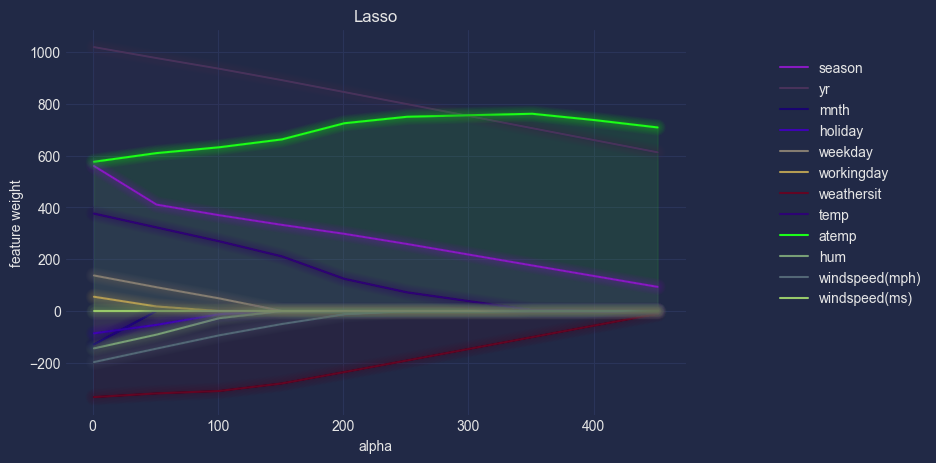

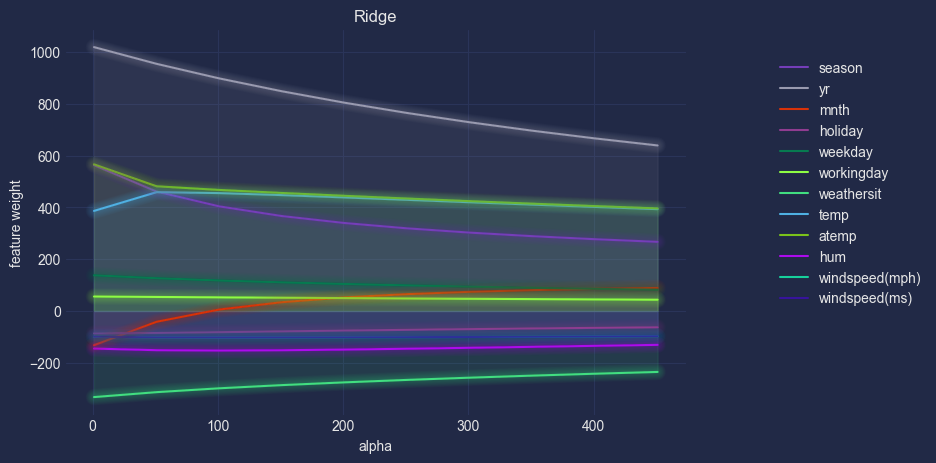

In [14]:
# Графіки для Lasso
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns[:-1]):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")
mplcyberpunk.add_glow_effects()

# Графіки для Ridge
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns[:-1]):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
mplcyberpunk.add_glow_effects()

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

Відповіді на запитання:

1. Lasso агресивніше зменшує ваги при тому самому значенні α порівняно з Ridge. У Lasso можна спостерігати велику кількість ваг, які зменшуються до нуля при зростанні α, що вказує на відбір ознак.

2. Якщо α в Lasso зробити дуже великим, то всі ваги ознак стануть нулями. Це відбувається через те, що Lasso використовує L1-регуляризацію, яка має властивість зменшувати ваги до нуля, що робить відбір ознак.

3. Так, Lasso може виключити одну з ознак windspeed за будь-якого значення α > 0, оскільки ваги можуть стати меншими за 10^-3 і, таким чином, вага ознаки зменшиться до нуля. Ridge зазвичай не виключає ознаки повністю, але зменшує їх значення.

4. Lasso підходить для відбору неінформативних ознак, так як вона може зменшити ваги до нуля і виключити ці ознаки з моделі. Ridge також зменшує ваги, але не виключає ознаки повністю, тому він менше підходить для відбору неінформативних ознак.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [15]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    mplcyberpunk.add_glow_effects()
    plt.show()


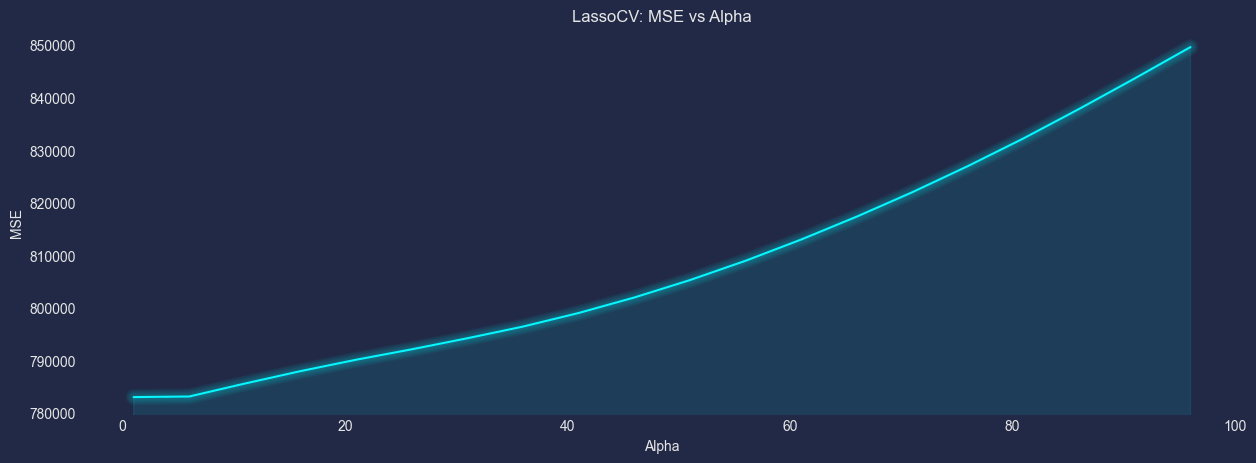

Selected Alpha: 1
Feature - Coefficient pairs:
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


In [16]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5).fit(X, y)

data = list(zip(regressor.alphas_, np.mean(regressor.mse_path_, axis=1)))

create_plot(data, "LassoCV: MSE vs Alpha", "Alpha", "MSE")

coefficients = list(zip(df.columns[:-1], regressor.coef_))
print(f"Selected Alpha: {regressor.alpha_}")
print("Feature - Coefficient pairs:")
for feature, coef in coefficients:
    print(f"{feature}: {coef}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alphas with minimum MSE:
Alpha = 1, MSE = 691447.2507878067
Alpha = 11, MSE = 883471.1829425399
Alpha = 1, MSE = 710110.162411734
Alpha = 26, MSE = 860737.405948872
Alpha = 21, MSE = 750676.3567790003


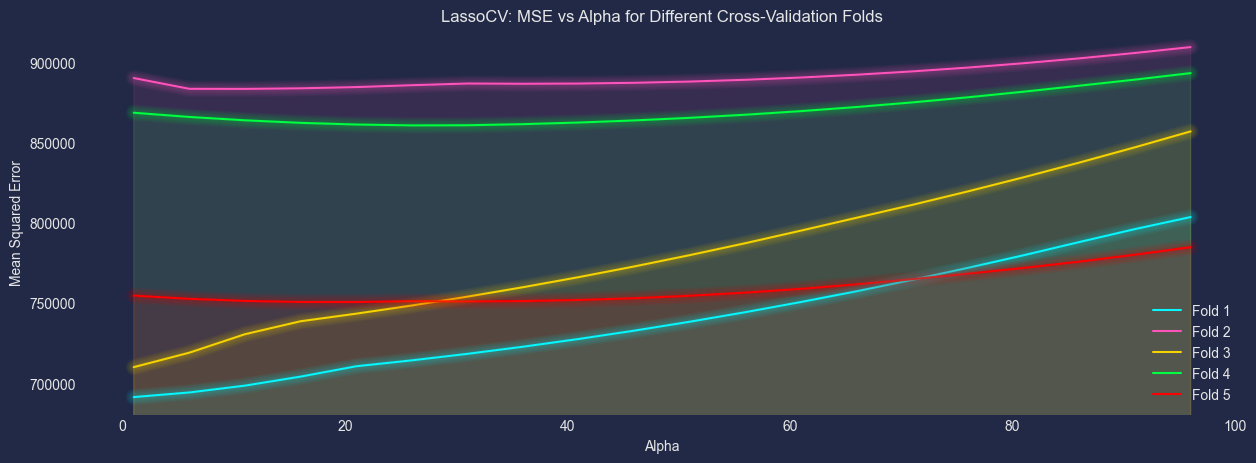

In [17]:
# Find alphas with minimum MSE for each column
min_alpha_indices = np.argmin(regressor.mse_path_, axis=0)
min_alphas = regressor.alphas_[min_alpha_indices]

# Print the results
print("Alphas with minimum MSE:")
for i, min_alpha in enumerate(min_alphas):
    mse = regressor.mse_path_[min_alpha_indices[i], i]
    print(f"Alpha = {min_alpha}, MSE = {mse}")

# Plot mse_path_ columns
plt.figure(figsize=(15, 5))
for i in range(regressor.mse_path_.shape[1]):
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f"Fold {i+1}")

plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("LassoCV: MSE vs Alpha for Different Cross-Validation Folds")
plt.legend()
plt.grid()
mplcyberpunk.add_glow_effects()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

Оберімо 4 ознаки з найбільшими (позитивними) коефіцієнтами:

1. yr (рік)
2. atemp (нормалізована відчутна температура)
3. season (сезон)
4. temp (нормалізована температура)

Давайте подивимося на візуалізації залежностей cnt від цих ознак:

1. Рік (yr): з графіку видно, що з ростом років (зростання з 0 до 1) кількість прокатів велосипедів зростає, що логічно, оскільки популярність прокату може зростати з часом.

2. Нормалізована відчутна температура (atemp): графік показує позитивну лінійну залежність між відчутною температурою і кількістю прокатів. Це означає, що при збільшенні відчутної температури більше людей взяло б велосипеди.

3. Сезон (season): гграфік показує, що в зимовий сезон (значення 1) кількість прокатів менше, а в літній (значення 3) і осінній (значення 4) сезони попит на велосипеди значно вищий.

4. Нормалізована температура (temp): також спостерігається позитивна залежність від температури, що дуже логічно, оскільки в теплу погоду більше людей віддає перевагу прокату велосипедів.

Отже, графіки дійсно вказують на зростаючу лінійну залежність cnt (кількість прокатів) від цих ознак, і логічно стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

Оберімо 3 ознаки з найбільшими за модулем негативними коефіцієнтами:

1. weathersit (погодні умови)
2. windspeed(mph) (швидкість вітру в милях на годину)
3. hum (вологість)

Давайте подивимося на відповідні візуалізації:

1. Погодні умови (weathersit): графік показує негативну лінійну залежність між погодними умовами і кількістю прокатів. Це означає, що при погіршенні погоди (збільшенні значень) менше людей бере велосипеди.

2. Швидкість вітру (windspeed(mph)): графік також показує негативну лінійну залежність. Чим вища швидкість вітру, тим менше людей взяло б велосипеди.

3. Вологість (hum): графік також вказує на негативну залежність. При збільшенні вологості кількість прокатів зменшується.

З цих графіків видно, що зі зростанням цих ознак кількість прокатів зменшується, тому логічно стверджувати, що чим більше величина.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

Ознаки з коефіцієнтами, близькими до нуля (<1e-3), в моделі можуть бути виключені через те, що вони мають слабий або незначний вплив на цільову змінну (кількість прокатів велосипедів). Однак це не завжди означає, що вони абсолютно не впливають на попит на велосипеди.

Модель приймає рішення про включення або виключення ознаки на підставі її впливу на цільову змінну в контексті інших доступних ознак. Якщо ознака має дуже слабий вплив або корелює з іншими ознаками, її можуть виключити з моделі для зменшення складності моделі та уникнення перенавчання.

Ознаки з коефіцієнтами, близькими до нуля, в даному випадку мають наступні значення:

1. windspeed(ms) (швидкість вітру в метрах на секунду): Коефіцієнт дуже близький до нуля. Ця ознака дублює ознаку windspeed(mph), яка використовується в моделі. Можливо, модель визнала, що обидві ознаки мають ідентичний вплив і обрала одну з них.

2. Деякі інші ознаки також мають коефіцієнти близькі до нуля. Можливо, ці ознаки не мають значущого статистичного впливу на цільову змінну в контексті інших ознак.

Звісно, не завжди можна однозначно стверджувати, що ознаки з коефіцієнтами, близькими до нуля, абсолютно не впливають на попит на велосипеди. Їх вплив може бути контекстуальним і залежати від конкретних обставин і взаємодії з іншими ознаками. Для точніших висновків про вплив конкретних ознак на попит на велосипеди може бути корисним проведення додаткового аналізу та експертної оцінки.


### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.